In [9]:
import os
import math
from sklearn.model_selection import train_test_split
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

device


device(type='cuda')

## tokenize input

In [10]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

## attention masks 

In [11]:
def create_attn_masks(input_ids):
    attention_masks = []
    
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
        
    return attention_masks

In [12]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
    
    def __init__(self, num_labels=2):
        super(XLNetForMultiLabelSequenceClassification, self).__init__()
        self.num_labels = num_labels       
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        self.classifier = torch.nn.Linear(768, num_labels)
        torch.nn.init.xavier_normal_(self.classifier.weight)
    
    def forward(self, input_ids, token_type_ids=None,attention_mask=None, labels=None):
        
        last_hidden_state = self.xlnet(input_ids=input_ids,attention_mask=attention_mask,\
                                       token_type_ids=token_type_ids)
    
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
        logits = self.classifier(mean_last_hidden_state)

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels),labels.view(-1, self.num_labels))
            return loss 
 
        else:
            return logits  

    def freeze_xlnet_decoder(self):
        for param in self.xlnet.parameters():
            param.requires_grad = False

    def unfreeze_xlnet_decoder(self):
        for param in self.xlnet.parameters():
            param.requires_grad = True

    def pool_hidden_state(self, last_hidden_state):
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state


In [13]:
def load_model(save_path):
    checkpoint = torch.load(save_path)
    model_state_dict = checkpoint['state_dict']
    model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
    model.load_state_dict(model_state_dict)

    epochs = checkpoint["epochs"]
    lowest_eval_loss = checkpoint["lowest_eval_loss"]
    train_loss_hist = checkpoint["train_loss_hist"]
    valid_loss_hist = checkpoint["valid_loss_hist"]

    return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

## make predictions 

In [ ]:
# LOAD MODEL 
path = 'path/to/model/xlnet.dat'

model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(path)

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [16]:
# load df CORD19 document types  
df_test = pd.read_csv('path/to/dataset/CORD19_full_labels.csv', sep='\t')

# drop document with no abstract
df_test.dropna(subset = ['title', 'abstract'], inplace=True)

df_test['document'] = [x + ' ' + y for x,y in zip(df_test.title, df_test.abstract)]

# create features and mask columns 
text_list = df_test["document"].values
input_ids = tokenize_inputs(text_list, tokenizer, num_embeddings = 700)
attention_masks = create_attn_masks(input_ids)


# add input ids and attention masks to the dataframe
df_test["features"] = input_ids.tolist()
df_test["masks"] = attention_masks


df_test


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,label,document,features,masks
0,jq2em42q,NaN,Medline,The end of social confinement and COVID-19 re-...,10.1038/s41562-020-0908-8,NaN,32572175,unk,The lack of effective pharmaceutical intervent...,2020-06-22,...,NaN,NaN,NaN,NaN,https://doi.org/10.1038/s41562-020-0908-8; htt...,219958669.0,primary-not-rct,The end of social confinement and COVID-19 re-...,"[18, 239, 20, 796, 25085, 21, 830, 7791, 13, 8...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,zcxwnvy2,NaN,Medline,The Missing Link in the Covid-19 Vaccine Race.,10.1080/21645515.2020.1831859,NaN,33079612,unk,Operation Warp Speed and global vaccine resear...,2020-10-20,...,NaN,NaN,NaN,NaN,https://doi.org/10.1080/21645515.2020.1831859;...,224826061.0,excluded,The Missing Link in the Covid-19 Vaccine Race....,"[18, 2279, 1730, 25, 18, 830, 7791, 13, 815, 9...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,izqvn6nr,NaN,Medline,Donor To Recipient Transmission Of SARS-CoV-2 ...,10.1111/ajt.16532,NaN,33565705,unk,We describe a case of proven transmission of S...,2021-02-10,...,NaN,NaN,NaN,NaN,https://doi.org/10.1111/ajt.16532; https://www...,231872023.0,primary-not-rct,Donor To Recipient Transmission Of SARS-CoV-2 ...,"[11587, 22, 9533, 5795, 20, 17, 7970, 23, 13, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,r17yloy3,NaN,Medline,Neonates Born to Mothers With COVID-19: Data F...,10.1542/peds.2020-015065,NaN,33479162,unk,OBJECTIVES To describe neonatal and maternal c...,2021-01-21,...,NaN,NaN,NaN,NaN,https://doi.org/10.1542/peds.2020-015065; http...,231676588.0,primary-not-rct,Neonates Born to Mothers With COVID-19: Data F...,"[27256, 7861, 1094, 22, 10907, 33, 830, 7791, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,20p9lr62,NaN,Medline,New targets for drug design: Importance of nsp...,10.1111/febs.15815,NaN,33705595,unk,SARS-CoV-2 virus has triggered a global pandem...,2021-03-11,...,NaN,NaN,NaN,NaN,https://doi.org/10.1111/febs.15815; https://ww...,232208657.0,excluded,New targets for drug design: Importance of nsp...,"[109, 4568, 28, 1208, 811, 60, 2945, 20, 17, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,9asnam5x,NaN,Medline,Establishing a COVID-19 treatment centre in Is...,10.1136/emermed-2020-209639,NaN,33771818,unk,Anticipating the need for a COVID-19 treatment...,2021-03-26,...,NaN,NaN,NaN,NaN,https://doi.org/10.1136/emermed-2020-209639; h...,232369853.0,primary-not-rct,Establishing a COVID-19 treatment centre in Is...,"[7382, 24, 830, 7791, 13, 815, 1225, 2448, 25,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6,y4p2ogrz,NaN,Medline,Guidelines for Ultrasound in the Radiology Dep...,10.1097/ruq.0000000000000526,NaN,32890322,unk,The coronavirus disease 2019 is caused by the ...,2020-09-01,...,NaN,NaN,NaN,NaN,https://doi.org/10.1097/ruq.0000000000000526; ...,221511545.0,broad-synthesis,Guidelines for Ultrasound in the Radiology Dep...,"[5213, 28, 25404, 25, 18, 1242, 8932, 1733, 18...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7,9zi08xl7,NaN,Medline,Antiphospholipid antibodies and thrombosis in ...,10.1002/art.41634,NaN,33381888,unk,We read with great interest the study by Berti...,2020-12-31,...,NaN,NaN,NaN,NaN,https://doi.org/10.1002/art.41634; https://www...,229928885.0,primary-not-rct,Antiphospholipid antibodies and thrombosis in ...,"[932, 29960, 8562, 1500, 26308, 21, 17, 8919, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
9,c1xd4mtz,NaN,Medline,Nonoperating room anesthesia for patients with...,10.1097/aco.0000000000000890,NaN,32628408,unk,PURPOSE OF REVIEW To provide aids to deal with...,2020-08-01,...,NaN,NaN,NaN,NaN,https://doi.org/10.1097/aco.0000000000000890; ...,220388324.0,excluded,Nonoperating room anesthesia for patients with...,"[555, 9855, 2076, 520, 48, 24503, 28, 1569, 33...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, .

In [17]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
    
    num_iter = math.ceil(df.shape[0]/batch_size)
    pred_probs = np.array([]).reshape(0, num_labels)
    
    #embedding_dim = 768
    #document_embeddings = np.empty(shape= (num_iter*batch_size, embedding_dim))
    
    model.to(device)
    model.eval()
    
    for i in range(num_iter):
        
        print('{}/{}'.format(i, num_iter), end='\r')
        
        df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
        X = df_subset["features"].values.tolist()
        masks = df_subset["masks"].values.tolist()
        X = torch.tensor(X)
        masks = torch.tensor(masks, dtype=torch.long)
        X = X.to(device)
        masks = masks.to(device)
        
        with torch.no_grad():
            
            logits = model(input_ids=X, attention_mask=masks)
            logits = logits.sigmoid().detach().cpu().numpy()
            pred_probs = np.vstack([pred_probs, logits])
            
            # add embeddings 
            #document_embeddings[i][:embedding_dim] = embeddings.cpu().detach()

    return pred_probs #, document_embeddings

num_labels = 5

# give test DF from above 
pred_probs = generate_predictions(model, df_test, num_labels, device="cuda", batch_size=40)

In [18]:
predictions = np.argmax(pred_probs, axis=1)

df_test['pred'] = predictions

df_test['probs'] = [row.tolist() for row in pred_probs]


In [19]:
gt = []

for x in df_test.label:
    
    if x == 'systematic-review':
        gt.append(4)
    
    elif x == 'primary-not-rct':
        gt.append(3)
    
    elif x == 'primary-rct':
        gt.append(2)
    
    elif x == 'excluded':
        gt.append(1)
    
    elif x == 'broad-synthesis':
        gt.append(0)


In [20]:
df_test['ground_truth'] = gt

In [21]:
gt = np.array(df_test.ground_truth)
preds = np.array(df_test.pred)


## generate prediction reports 
- Confusion matrix
- Metrics report 


RESULTS XLNET 


[Text(69,0.5,'True Label'), Text(0.5,42,'Predicted Label')]

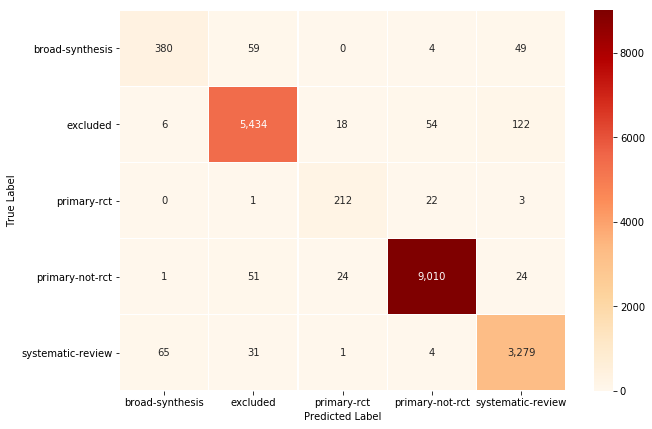

In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix

print('\nRESULTS XLNET ')

array = confusion_matrix(gt, preds)

df_cm = pd.DataFrame(array, index = [i for i in [ 'broad-synthesis', 'excluded' , 'primary-rct' , 'primary-not-rct'  , 'systematic-review']],
                     
                  columns = [i for i in [ 'broad-synthesis', 'excluded' , 'primary-rct' ,'primary-not-rct' , 'systematic-review']])

plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, linewidths = 0.5, xticklabels = True, yticklabels = True, cmap = "OrRd", annot = True, fmt = "d")

for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))

ax.set(xlabel='Predicted Label', ylabel='True Label')

In [23]:
from sklearn.metrics import classification_report
print(classification_report(gt, preds))

             precision    recall  f1-score   support

          0       0.84      0.77      0.81       492
          1       0.97      0.96      0.97      5634
          2       0.83      0.89      0.86       238
          3       0.99      0.99      0.99      9110
          4       0.94      0.97      0.96      3380

avg / total       0.97      0.97      0.97     18854

